# PET data case

Tested with CIL 21.1.0 and SIRF 3.0.0

The data is a real dataset of a phantom acquisition at UCL on a Siemens mMR. The phantom is the NEMA phantom (essentially a torso-shaped perspex box, with some spherical inserts).  The data is freely available on [Zenodo](https://zenodo.org/record/1304454#.YJU7xbVKg10).

The data must be downloaded and put in a the directory pointed by `data_path`.

Parts of this notebook are taken from the SIRF exercise [reconstruct_measured_data ](https://github.com/SyneRBI/SIRF-Exercises/blob/master/notebooks/PET/reconstruct_measured_data.ipynb) from CCP SyneRBI.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import sirf.STIR as pet
from sirf.config import SIRF_HAS_Parallelproj

from cil.utilities.display import show2D
from cil.optimisation.algorithms import PDHG, SPDHG
from cil.optimisation.functions import KullbackLeibler
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from ccpi.filters import regularisers


# The data is prepared as in the SIRF-Exercises reconstruct_measured_data 
# change data_path to point to the directory where the data has been downloaded and unzipped
data_path = os.path.abspath('/home/jovyan/work/SIRF-Exercises/data/working_folder/PET/reconstruct_measured_data')
os.chdir(data_path)
sirf_data_path = os.path.abspath('/home/jovyan/work/SIRF-Exercises/data/PET/mMR/NEMA_IQ')

In [2]:
# file names
# list_file = '20170809_NEMA_60min_UCL.l.hdr'
list_file = os.path.join(sirf_data_path, '20170809_NEMA_60min_UCL.l.hdr')
norm_file = 'norm.n.hdr'
# attn_file = 'mu_map.hv'
attn_file = 'umap.v.hdr'
# output filename prefixes
sino_file = 'sino'

In [3]:
# redirect STIR messages to some files
# you can check these if things go wrong
msg_red = pet.MessageRedirector('info.txt', 'warn.txt')

In [4]:
template_acq_data = pet.AcquisitionData('Siemens_mMR', span=11, max_ring_diff=15, view_mash_factor=1)
template_acq_data.write('template.hs')
# create listmode-to-sinograms converter object
lm2sino = pet.ListmodeToSinograms()

# set input, output and template files
lm2sino.set_input(list_file)
lm2sino.set_output_prefix(sino_file)
lm2sino.set_template('template.hs')
# set timing interval (in secs) since start of acquisition
# (the listmode file provided is for 1 hour).
# you can vary this to see the effect on noise. Increasing it will mean somewhat longer
# processing time in the following steps (but not in the reconstruction).
lm2sino.set_time_interval(0, 500)
# set up the converter
lm2sino.set_up()
# create the prompts sinogram
lm2sino.process()
# get access to the sinograms
# acq_data = lm2sino.get_output()
acq_data = pet.AcquisitionData('sino_f1g1d0b0.hs')

# use a slice number for display that is appropriate for the NEMA phantom
z = 71

# uncomment to show the acquisition data
# show2D(acq_data, slice_list=[(0,0),(1,z)], title='500s', cmap='gray_r' )


INFO: CListModeDataECAT8_32bit: opening file /home/jovyan/work/SIRF-Exercises/data/PET/mMR/NEMA_IQ/20170809_NEMA_60min_UCL.l
13000000 events stored


Processing time frame 1

Number of prompts stored in this time period : 13043732
Number of delayeds stored in this time period: 0
Last stored event was recorded before time-tick at 500 secs
Total number of counts (either prompts/trues/delayeds) stored: 13043732

This took 13.63s CPU time.


In [5]:
# Get the randoms estimate
# This will take a while
rand = lm2sino.estimate_randoms()
rand.write('sino_randoms_f1g1d0b0')

# uncomment to show the randoms
# show2D(rand, slice_list=[(0,0),(1,z)], title='randoms 500s', cmap='gray_r')

Last stored event was recorded after time-tick at 499.999 secs
Total number of prompts/trues/delayed stored: 3506594

This took 5.51s CPU time.


estimate_randoms: trying GEHDF5...
not a GE HDF5 file. Using ML estimate from delayeds
processed frame 1
Starting iteration 1	KL 1941.92
Starting iteration 2	KL 142.99
Starting iteration 3	KL 5.14518
Starting iteration 4	KL 0.218351
Starting iteration 5	KL 0.00904963
Starting iteration 6	KL 0.000365185
Starting iteration 7	KL 1.62128e-05
Starting iteration 8	KL 3.8093e-07
Starting iteration 9	KL 8.08076e-09
Starting iteration 10	KL 1.15392e-09
CPU time 33.12 secs


## OSEM reconstruction

In [6]:
# Acquisition data stored in memory
pet.AcquisitionData.set_storage_scheme('memory')
pet.set_verbosity(0)

# attenuation
attns = pet.ImageData(attn_file)
asm_norm = pet.AcquisitionSensitivityModel(norm_file)

# Setup image geometry
image = acq_data.create_uniform_image(0., (127, 220, 220))
image.initialise(dim=(127, 220, 220), vsize=(2.03125, 1.7080754, 1.7080754))

def get_asm_attn(sino, attn, acq_model):
    """Get attn Attenuation Sensitivity Model from sino, attn image and acq model."""
    asm_attn = pet.AcquisitionSensitivityModel(attn, acq_model)
    # temporary fix pending attenuation offset fix in STIR:
    # converting attenuation into 'bin efficiency'
    asm_attn.set_up(sino)
    bin_eff = pet.AcquisitionData(sino)
    bin_eff.fill(1.0)
    asm_attn.unnormalise(bin_eff)
    asm_attn = pet.AcquisitionSensitivityModel(bin_eff)
    return asm_attn

# set up the acquisition model
if SIRF_HAS_Parallelproj:
    # use a GPU implementation if available
    am = pet.AcquisitionModelUsingParallelproj()
else:
    am = pet.AcquisitionModelUsingRayTracingMatrix()

# ASM norm already there
asm_attn = get_asm_attn(acq_data,attns,am)

# Get ASM dependent on attn and/or norm
asm = pet.AcquisitionSensitivityModel(asm_norm, asm_attn)
am.set_acquisition_sensitivity(asm)
am.set_background_term(rand)
am.set_up(acq_data, image)

Reading manufacturer PET normalisation file from norm.n.hdr


In [7]:
# setup OSEM
obj_fun = pet.make_Poisson_loglikelihood(acq_data)
obj_fun.set_acquisition_model(am)

recon = pet.OSMAPOSLReconstructor()
recon.set_objective_function(obj_fun)
recon.set_num_subsets(21)
recon.set_num_subiterations(12)
recon.set_up(image)

# set the initial image estimate
recon.set_current_estimate(image)

In [8]:
# run OSEM
recon.process()
osem_recon = recon.get_output()

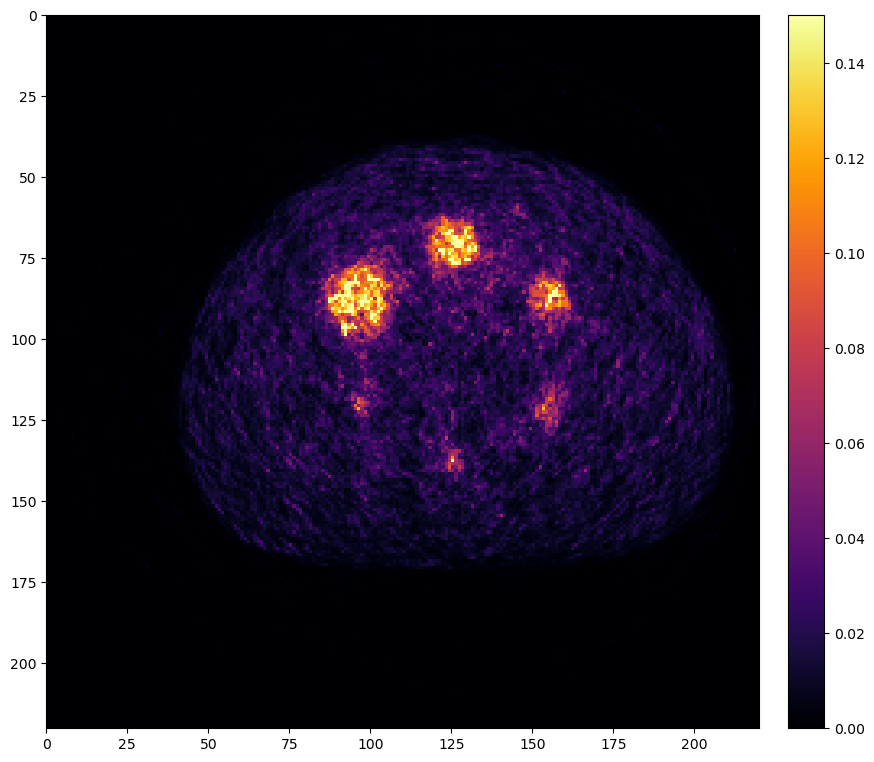

In [9]:
# show OSEM recon
show2D(osem_recon.as_array()[72,:,:], cmap="inferno", fix_range=(0,0.15), origin="upper")

## Reconstruction with TV regularisation using PDHG and preconditioning

In [10]:


# Get linear acquisition model
K = am.get_linear_acquisition_model()

To accelerate the reconstruction, we use diagonal preconditioning to compute $\sigma$ and $\tau$ based on the operator K. See [here](https://ieeexplore.ieee.org/document/6126441) for more information.

In [11]:
tmp_sigma = K.direct(K.domain_geometry().allocate(1.)).power(-1)
tmp_tau   = K.adjoint(K.range_geometry().allocate(1.)).power(-1)

tmp_tau_np = tmp_tau.as_array()
tmp_tau_np[tmp_tau_np==np.inf] = 1e-5
tau = tmp_tau*0.
tau.fill(tmp_tau_np)

tmp_sigma_np = tmp_sigma.as_array()
tmp_sigma_np[tmp_sigma_np==np.inf] = 1e-5
sigma = tmp_sigma*0.
sigma.fill(tmp_sigma_np)

The implementation of `FGP_TV` does not accept $\tau$ as a `numpy` array. Hence, we change its `proximal` method to a `precond_proximal` method. 

In [12]:
def precond_proximal(self,x,tau, out=None):
        in_arr = np.asarray(x.as_array()/tau.as_array(), dtype=np.float32, order='C')      
        res , info = regularisers.FGP_TV(\
              in_arr,\
              self.alpha,\
              self.max_iteration,\
              self.tolerance,\
              self.methodTV,\
              self.nonnegativity,\
              self.device)
        if out is not None:
            out.fill(res)
        else:
            out = x.copy()
            out.fill(res)
        out *= tau    
        return out    
    
FGP_TV.proximal = precond_proximal

Next, we define the fidelity term **KullbackLeibler** based on the acqusition data and random events. For the regularisation term we use the **FGP_TV** function class from the [CCPi-RegTk](https://github.com/vais-ral/CCPi-Regularisation-Toolkit).

In [13]:
alpha = 13.0
F = KullbackLeibler(b = acq_data, eta = rand)
G = alpha * FGP_TV(max_iteration=100, device='gpu' )
max_iterations = 500 # Use 500 to match the results in the paper. 

# Setup and run PDHG
pdhg = PDHG(f = F, g = G, operator=K, sigma = sigma, tau = tau,
            max_iteration = max_iterations, update_objective_interval = 100)

/opt/SIRF-SuperBuild/INSTALL/python/cil/optimisation/algorithms/PDHG.py:397: UserWarning: Convergence criterion can only be checked for scalar values of tau and sigma.
  warnings.warn("Convergence criterion can only be checked for scalar values of tau and sigma.")


In [15]:
# Image metrics callback
import img_quality_cil_stir as imgq
import tensorboardX
from datetime import datetime
import numpy as np
# create a tensorboardX summary writer
dt_string = datetime.now().strftime("%Y%m%d-%H%M%S")
tb_summary_writer = tensorboardX.SummaryWriter(f'recons/exp-{dt_string}')
def MSE(x,y):
    """ mean squared error between two numpy arrays
    """
    return ((x-y)**2).mean()

def MAE(x,y):
    """ mean absolute error between two numpy arrays
    """
    return np.abs(x-y).mean()

def PSNR(x, y, scale = None):
    """ peak signal to noise ratio between two numpy arrays x and y
        y is considered to be the reference array and the default scale
        needed for the PSNR is assumed to be the max of this array
    """
  
    mse = ((x-y)**2).mean()
  
    if scale == None:
        scale = y.max()
  
    return 10*np.log10((scale**2) / mse)

ground_truth = osem_recon
roi_image_dict = {}
# instantiate ImageQualityCallback
img_qual_callback = imgq.ImageQualityCallback(ground_truth, tb_summary_writer,
                                              roi_mask_dict = roi_image_dict,
                                              metrics_dict = {'MSE':MSE, 
                                                              'MAE':MAE, 
                                                              'PSNR':PSNR},
                                              statistics_dict = {'MEAN': (lambda x: x.mean()),
                                                                 'STDDEV': (lambda x: x.std()),
                                                                 'MAX': (lambda x: x.max()),
                                                                 'COM': (lambda x: np.array([3,2,1]))},
                                              )
sigmas_mm = [5.0, 8.0]
filters = {}
for sigma in sigmas_mm:
    filters[f"Gaussian_{sigma}"] = imgq.image_quality_callback.GaussianFilter(post_smoothing_fwhm_mm=sigma, voxel_size_mm=img_qual_callback.voxel_size_mm)

img_qual_callback.set_filters(filters)


In [17]:
from cil.optimisation.utilities import callbacks

In [18]:
pdhg.run(callbacks=[callbacks.ProgressCallback(), img_qual_callback])

/tmp/ipykernel_295590/4217939724.py:1: DeprecationWarning: `run()` missing `iterations`
  pdhg.run(callbacks=[callbacks.ProgressCallback(), img_qual_callback])
/opt/conda/lib/python3.10/site-packages/numba/core/typed_passes.py:334: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../../../../opt/SIRF-SuperBuild/INSTALL/python/cil/optimisation/functions/KullbackLeibler.py", line 344:
    @njit(parallel=True)
    def kl_div(x, y, eta):
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10,10))
ss = 72
plt.imshow(osem_recon.as_array()[ss,:,:], cmap="inferno", vmax = 0.15)
plt.title("OSEM")
plt.plot((125,125),(0,219),'-r')
plt.colorbar()
# plt.savefig("osem_annot.png",dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(pdhg.solution.as_array()[ss,:,:], cmap="inferno", vmax = 0.15)
plt.title("PDHG + TV")
plt.plot((125,125),(0,219),'-r')
plt.colorbar()
# plt.savefig("pdhgtv_annot.png",dpi=300)
plt.show()

In [ ]:
plt.figure()
plt.plot(osem_recon.as_array()[72,:,125],label='OSEM')
plt.plot(pdhg.solution.as_array()[72,:,125],label='PDHG TV')
plt.legend()
# plt.savefig('vertical_profile.png',dpi=300)
plt.show()

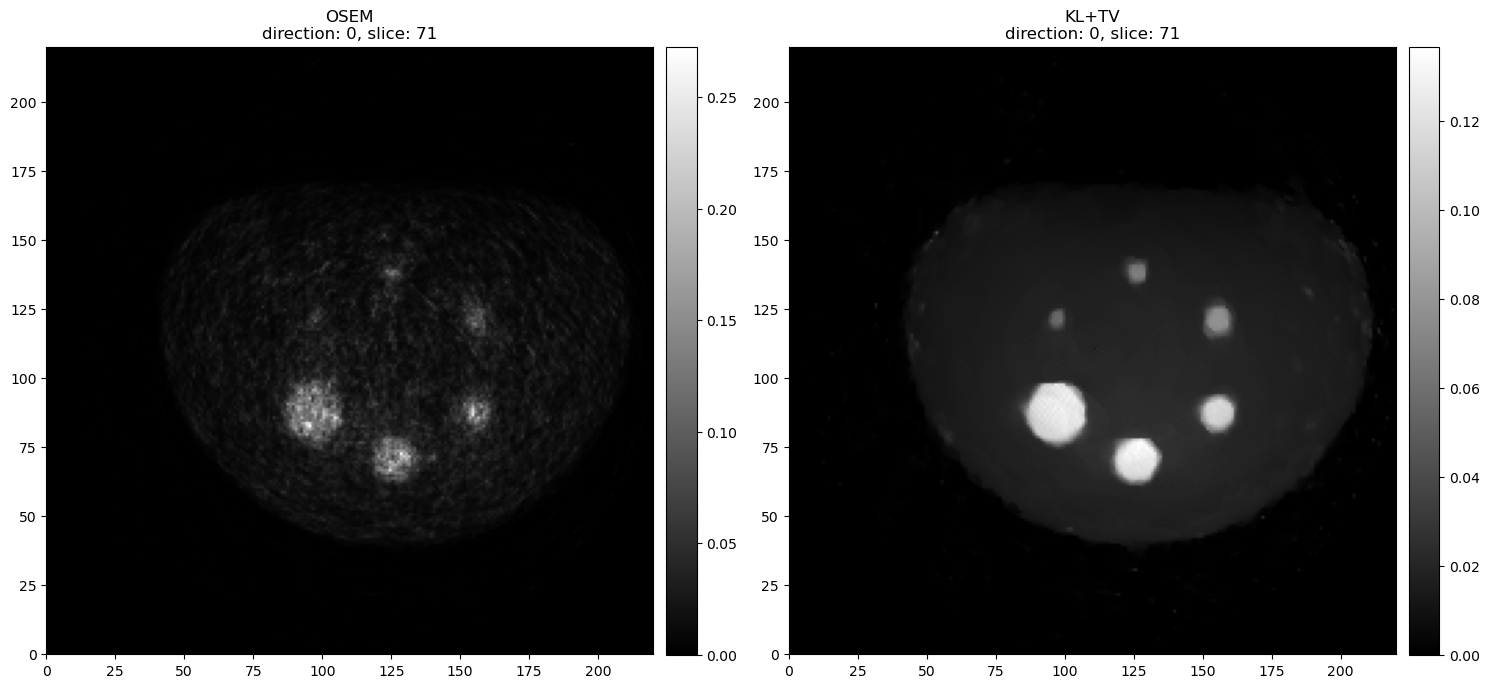

In [31]:
show2D([osem_recon, pdhg.solution], slice_list=(0,71), title=['OSEM', 'KL+TV'])